In [12]:

# # Load the AT&T faces dataset
# att_faces = fetch_olivetti_faces()

# # Reshape images to 2D array
# images = att_faces.images.reshape((len(att_faces.images), -1))
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split
import numpy as np

def load_att_faces_dataset():
    # Load the AT&T faces dataset
    att_faces = fetch_olivetti_faces()

    # Reshape images to 2D array
    images = att_faces.images.reshape((len(att_faces.images), -1))

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(images, att_faces.target, test_size=0.2, random_state=42)

    # Normalize pixel values to range [0, 1]
    min_ = np.min(images)
    max_ = np.max(images)
    X_train = (X_train - min_) / (max_ - min_)
    X_test = (X_test - min_) / (max_ - min_)

    return (X_train, y_train), (X_test, y_test), min_, max_

# Usage
(x_train, y_train), (x_test, y_test), min_, max_ = load_att_faces_dataset()


In [53]:
print(x_train.shape)

(320, 64, 64, 1)


In [9]:
num_samples_training_set = x_train.shape[0]

print("Number of samples in the training set:", num_samples_training_set)
# Count the number of distinct values in y_train
num_classes = len(np.unique(y_train))
print("Number of distinct values in y_train:", num_classes)
print(min_,max_)

Number of samples in the training set: 320
Number of distinct values in y_train: 40
0.0 1.0


In [3]:
import warnings
# warnings.filterwarnings('ignore')
import keras.backend as k
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
import numpy as np
from numpy.random import seed
seed(123)

from art.estimators.classification import KerasClassifier
from art.attacks.inference.model_inversion.mi_face import MIFace
from art.utils import load_dataset

%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
tf.compat.v1.disable_eager_execution()

C:\Users\Asus\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:


# Define the CNN model
def cnn_atandt(input_shape, min_val, max_val):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))  # Assuming 10 classes for MNIST dataset

    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    classifier = KerasClassifier(clip_values=(min_val, max_val), model=model, use_logits=False)
    return classifier



In [5]:
img_x_size=64
img_y_size=64

In [14]:
num_epochs = 60

# Reshape input data to match the expected input shape of the CNN model
x_train = x_train.reshape(-1, 64, 64, 1)  # Assuming images are 64x64 pixels with a single channel (grayscale)
x_test = x_test.reshape(-1, 64, 64, 1)

# Construct and train the CNN model
print(x_train.shape[1:])
classifier = cnn_atandt(x_train.shape[1:], min_, max_)
classifier.fit(x_train, y_train, nb_epochs=num_epochs, batch_size=128)
from sklearn.metrics import accuracy_score

# Get the predictions of the classifier on the test data
y_pred = classifier.predict(x_test)

# Convert the predictions to integer labels if necessary
y_pred = np.argmax(y_pred, axis=1)
# Compute accuracy using accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Accuracy on test data:", accuracy)

# Optionally, if you want to convert integer labels to one-hot encoded labels
# from keras.utils import to_categorical
# y_train_one_hot = to_categorical(y_train)


(64, 64, 1)
Accuracy on test data: 0.9625


c:\Users\Asus\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [31]:

# Create the attack.
# Note: by setting the threshold to 1., the attack will effectively exhaust the maximum number of iterations.

attack = MIFace(classifier, max_iter=20000, threshold=1.) 

In [32]:
num_classes2 = 15
y = np.arange(num_classes2)
print(y)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [33]:
# We will experiment with a number of different initializations:

x_init_white = np.zeros((num_classes2, 64, 64, 1))
x_init_grey = np.zeros((num_classes2, 64, 64, 1)) + 0.5
x_init_black = np.ones((num_classes2, 64, 64, 1))
x_init_random = np.random.uniform(0, 3, (num_classes2, 64, 64, 1))
x_init_average = np.zeros((num_classes2, 64, 64, 1)) + np.mean(x_test, axis=0)

In [34]:
# We observe that the classifier's gradients are vanishing on white images, therefore the attack won't work:

print("Maximum class gradient: %f" % (np.max(np.abs(classifier.class_gradient(x_init_white, y)))))

Maximum class gradient: 0.005823


In [35]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_grey, y)
class_gradient = np.reshape(class_gradient, (num_classes2 ,64*64))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000001


In [36]:
%%time

# Now we run the attack:
x_infer_from_grey = attack.infer(x_init_grey, y)

Model inversion: 100%|██████████| 15/15 [31:35<00:00, 126.34s/it]

CPU times: total: 11min 52s
Wall time: 31min 35s


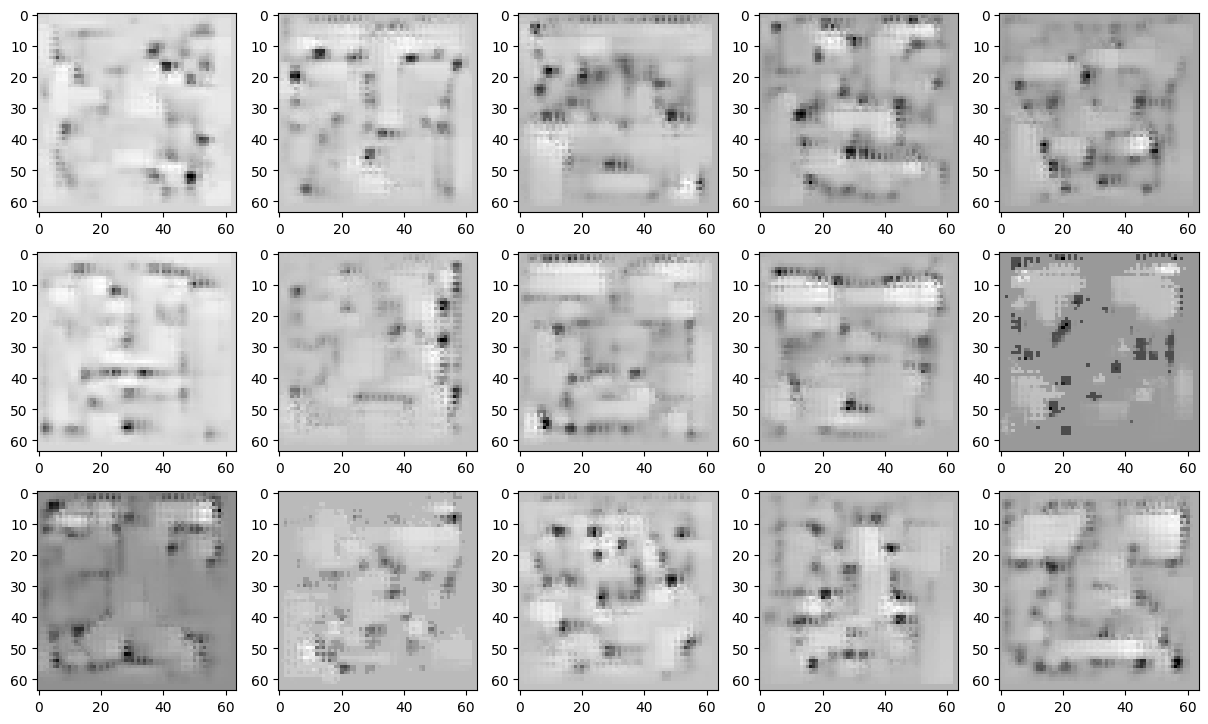

In [40]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(num_classes2):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_grey[0+i,], (64, 64))), cmap=plt.cm.gray_r)

### Initialization with black image

In [41]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_black, y)
class_gradient = np.reshape(class_gradient, (num_classes2, 64*64))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000000


In [43]:
%%time

# Now we run the attack:
x_infer_from_black = attack.infer(x_init_black, y)

Model inversion: 100%|██████████| 15/15 [32:04<00:00, 128.28s/it]

CPU times: total: 14min 12s
Wall time: 32min 4s


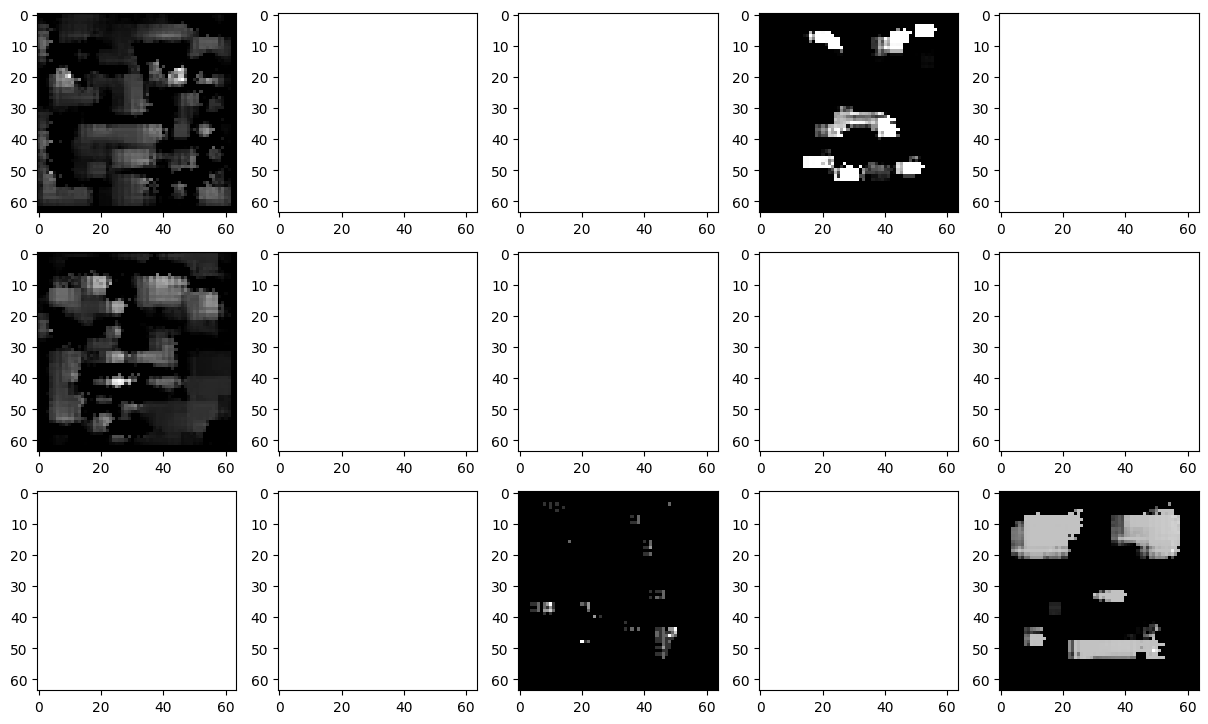

In [52]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(num_classes2):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_black[0+i,], (64,64))), cmap=plt.cm.gray_r)

### Initialization with random image

In [45]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_random, y)
class_gradient = np.reshape(class_gradient, (num_classes2, 64*64))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000000


In [46]:
%%time

# Now we run the attack:
x_infer_from_random = attack.infer(x_init_random, y)

Model inversion: 100%|██████████| 15/15 [31:39<00:00, 126.61s/it]

CPU times: total: 13min 26s
Wall time: 31min 39s


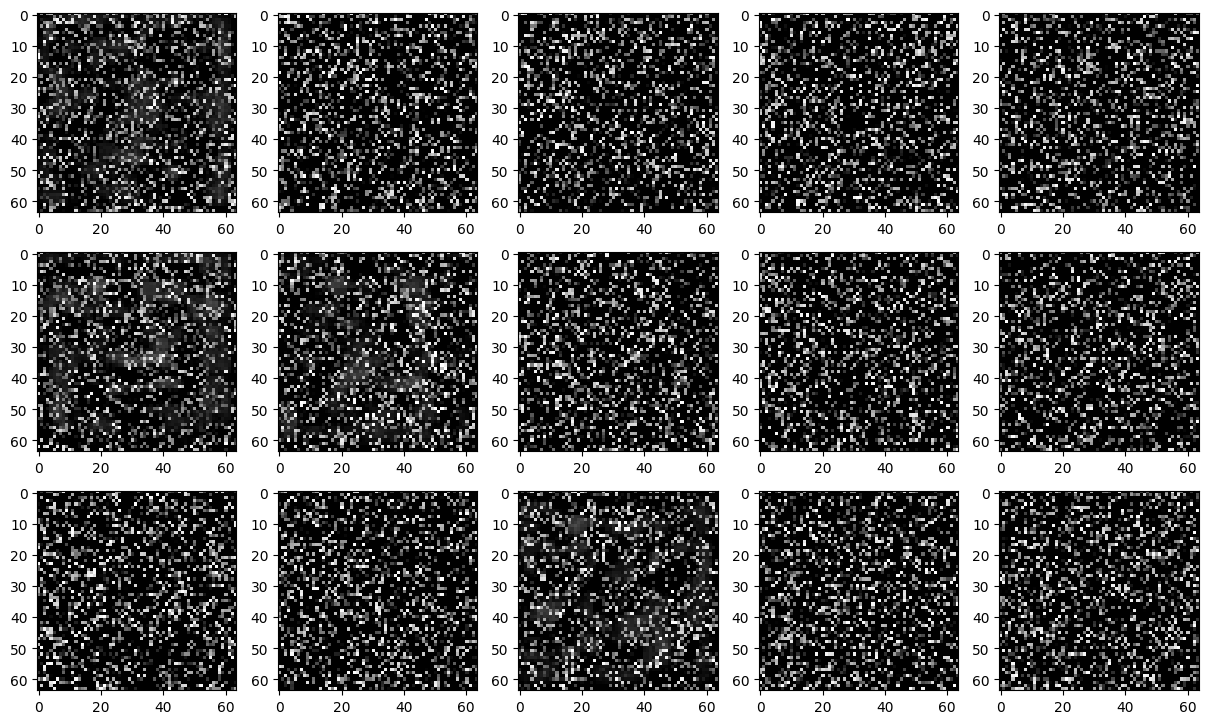

In [47]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(num_classes2):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_random[0+i,], (64,64))), cmap=plt.cm.gray_r)

### Initialization with average image

In [48]:
# First, we ensure that the classifier's gradients are non-vanishing for each target class:

class_gradient = classifier.class_gradient(x_init_average, y)
class_gradient = np.reshape(class_gradient, (num_classes2, 64*64))
class_gradient_max = np.max(class_gradient, axis=1)

print("Minimum over all maximum class gradient: %f" % (np.min(class_gradient_max)))

Minimum over all maximum class gradient: 0.000014


In [50]:
%%time

# Now we run the attack:
x_infer_from_average = attack.infer(x_init_average, y)

Model inversion: 100%|██████████| 15/15 [28:58<00:00, 115.92s/it]

CPU times: total: 12min 7s
Wall time: 28min 58s


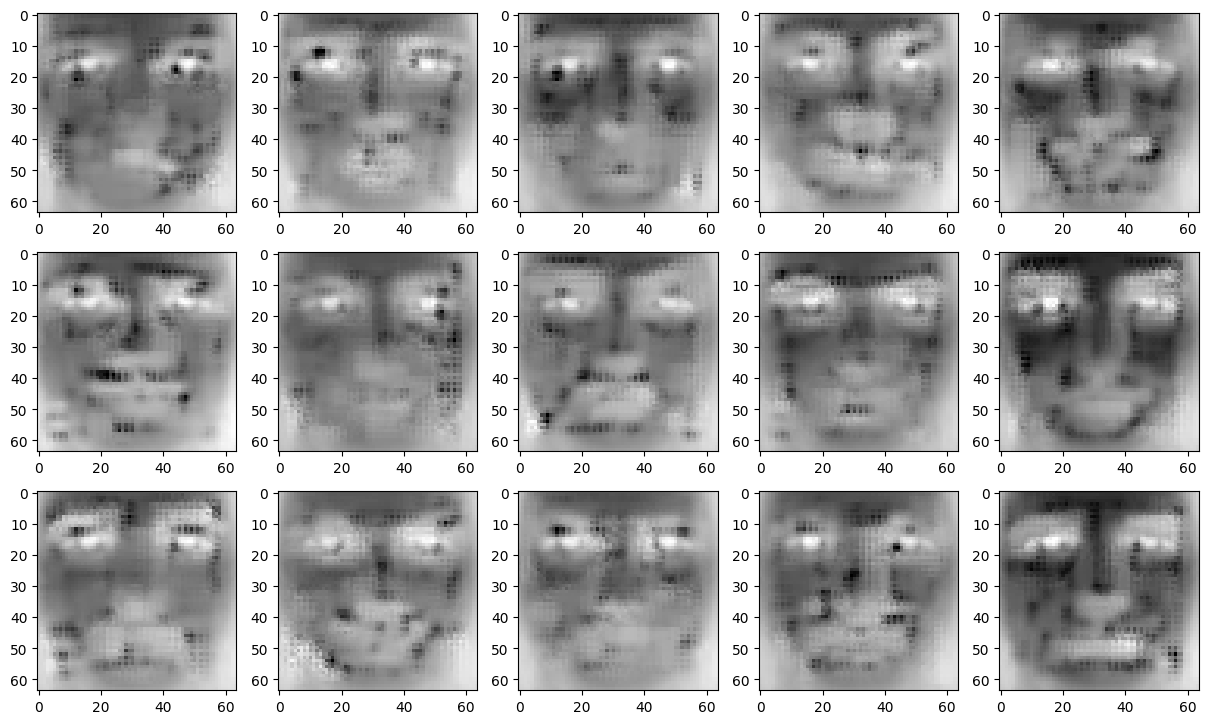

In [51]:
# Plot the inferred images:

plt.figure(figsize=(15,15))
for i in range(num_classes2):
    plt.subplot(5, 5, i + 1)
    plt.imshow( (np.reshape(x_infer_from_average[0+i,], (64,64))), cmap=plt.cm.gray_r)